In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
from icecube_utils import (
    inference, 
    convert_to_3d,
    calculate_angular_error,
    load_pretrained_model,
    build_model_simplex,
)
from train_large import config

graphnet: INFO     2023-03-31 04:52:28 - get_logger - Writing log to logs/graphnet_20230331-045228.log
graphnet: WARNING  2023-03-31 04:52:31 - warn_once - `icecube` not available. Some functionality may be missing.


ImportError: cannot import name 'build_model_simplex' from 'icecube_utils' (/workspace/icecube/icecube_utils.py)

In [ ]:
size_multiplier = 2
model_name = 'direction_mapped_contd'
state_dict_path = f'weights/{model_name}/state_dict.pth'

atan2 = False
zenith_uniform_to_zenith = None
# atan2 = True
# with open('data/fold_0.db.ecdf.pickle', 'rb') as f:
#     zenith_uniform_to_zenith = pickle.load(f)[1]

In [4]:
# %%capture --no-stdout 
# config['train_transforms'] = []
# config['dynedge']['dynedge_layer_sizes'] = [
#     (x * size_multiplier, y * size_multiplier) 
#     for x, y in [(128, 256), (336, 256), (336, 256), (336, 256)]
# ]
# config['batch_size'] = 200
# config['truth'] = ['zenith', 'azimuth']
# # config['target'] = 'direction'
# config['target'] = 'direction'
# config['path'] = '/workspace/data2/batch_14.db'
# config['inference_database_path'] = '/workspace/data2/batch_656.db'
# config['bias'] = True
# config['max_n_pulses']['max_n_pulses'] = 5000
# config['max_n_pulses']['max_n_pulses_strategy'] = 'random'
# # config['max_n_pulses']['max_n_pulses'] = None

# model = load_pretrained_model(
#     config=config, 
#     path=state_dict_path,
#     return_train_dataloader=False,
# )

# df = inference(
#     model.cuda(), 
#     config,
#     True
# )
# df.to_hdf(f'results/{model_name}_clamp_5000.h5', key='df', mode='w')
# df

In [ ]:
def xyz_to_angles(x, y, z):
    # norm = np.linalg.norm([x, y, z], ord=2)
    # x, y, z = x / norm, y / norm, z / norm

    azimuth = np.arctan2(y, x)
    azimuth[azimuth < 0] += 2 * np.pi
    
    zenith = np.arccos(z)

    return azimuth, zenith

def xyz_to_angles2(df):
    r = np.sqrt(df['direction_x']**2 + df['direction_y']**2 + df['direction_z']**2)
    df['zenith_pred'] = np.arccos(df['direction_z']/r)
    df['azimuth_pred'] = np.arctan2(df['direction_y'],df['direction_x']) 
    df['azimuth_pred'][df['azimuth_pred']<0] = df['azimuth_pred'][df['azimuth_pred']<0] + 2*np.pi 
    return df

def angles_to_xyz2(df):
    df['direction_x'] = np.sin(df['zenith_pred'])*np.cos(df['azimuth_pred'])
    df['direction_y'] = np.sin(df['zenith_pred'])*np.sin(df['azimuth_pred'])
    df['direction_z'] = np.cos(df['zenith_pred'])
    return df

def calculate_angular_error2(df):
    df = xyz_to_angles2(df)
    df = angles_to_xyz2(df)
    df['angular_error'] = np.arccos(df['direction_x']*df['true_x'] + df['direction_y']*df['true_y'] + df['direction_z']*df['true_z'])
    return df

def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.arccos(scalar_prod)

In [ ]:
df1 = pd.read_hdf('results/angles_euc_aug_no_clamp.h5', key='df')
# df1 = df1.drop(columns=['true_x', 'true_y', 'true_z', 'direction_x', 'direction_y', 'direction_z', 'angular_error'])
df1['direction_x'] = df1['azimuth_cos'] * df1['zenith_sin']
df1['direction_y'] = df1['azimuth_sin'] * df1['zenith_sin']
df1['direction_z'] = df1['zenith_cos']

norm = np.sqrt(df1['direction_x']**2 + df1['direction_y']**2 + df1['direction_z']**2)
df1['direction_x'] /= norm
df1['direction_y'] /= norm
df1['direction_z'] /= norm

# df1 = pd.read_hdf('results/baseline_no_clamp.h5', key='df')
df2 = pd.read_hdf('results/direction_mapped_contd_clamp_5000.h5', key='df')

# df1 = pd.read_hdf('results/direction.h5', key='df')
# df2 = pd.read_hdf('results/contd.h5', key='df')

df1 = xyz_to_angles2(df1)
df2 = xyz_to_angles2(df2)

# df2['zenith_pred'] = df2['zenith']
# df2['azimuth_pred'] = df2['azimuth']

df1['angular_error'] = angular_dist_score(df1['azimuth'], df1['zenith'], df1['azimuth_pred'], df1['zenith_pred'])
df2['angular_error'] = angular_dist_score(df2['azimuth'], df2['zenith'], df2['azimuth_pred'], df2['zenith_pred'])
df1['angular_error'].mean(), df2['angular_error'].mean()

(1.0200174911050286, 1.003304821005105)

In [ ]:
a, b = xyz_to_angles(df1['direction_x'], df1['direction_y'], df1['direction_z'])
df1['azimuth_pred'] = a
df1['zenith_pred'] = b

a, b = xyz_to_angles(df2['direction_x'], df2['direction_y'], df2['direction_z'])
df2['azimuth_pred'] = a 
df2['zenith_pred'] = b

In [ ]:
df = df1.copy()

# df['direction_x'] = (df1['direction_x'] + df2['direction_x']) / 2
# df['direction_y'] = (df1['direction_y'] + df2['direction_y']) / 2
# df['direction_z'] = (df1['direction_z'] + df2['direction_z']) / 2

# df['zenith_pred'] = (df1['zenith_pred'] + df2['zenith_pred']) / 2
# df['azimuth_pred'] = df2['azimuth_pred']

df['zenith_pred'] = df2['zenith_pred']
df['azimuth_pred'] = df2['azimuth_pred']
df2_bad_mask = df2['direction_kappa'] < 0.5
# df2_bad_mask2 = df2['zenith_pred'] < 0.1
# df.loc[df2_bad_mask, 'zenith_pred'] = df1.loc[df2_bad_mask, 'zenith_pred']
df.loc[df2_bad_mask, 'azimuth_pred'] = df1.loc[df2_bad_mask, 'azimuth_pred']

# df['zenith_pred'] = (df1['zenith_pred'] + df2['zenith_pred']) / 2
# df['azimuth_pred'] = (df1['azimuth_pred'] + df2['azimuth_pred']) / 2

# df['zenith_pred'] = df2['zenith_pred']
# df['azimuth_pred'] = df2['azimuth_pred']
# df2_bad_mask = df2['direction_kappa'] < 1
# df.loc[df2_bad_mask, 'zenith_pred'] = df1.loc[df2_bad_mask, 'zenith_pred']
# df.loc[df2_bad_mask, 'azimuth_pred'] = df1.loc[df2_bad_mask, 'azimuth_pred']
# df.loc[~df2_bad_mask, 'zenith_pred'] = (df1.loc[~df2_bad_mask, 'zenith_pred'] + df2.loc[~df2_bad_mask, 'zenith_pred']) / 2
# df.loc[~df2_bad_mask, 'azimuth_pred'] = (df1.loc[~df2_bad_mask, 'azimuth_pred'] + df2.loc[~df2_bad_mask, 'azimuth_pred']) / 2

# df['zenith_pred'] = df2['zenith_pred']
# df['azimuth_pred'] = df2['azimuth_pred']
# df2_bad_mask = df2['direction_kappa'] < 1
# df['zenith_pred'] = df1['zenith_pred']
# df.loc[df2_bad_mask, 'azimuth_pred'] = df1.loc[df2_bad_mask, 'azimuth_pred']

def angles_to_xyz(azimuth, zenith):
    x = np.cos(azimuth) * np.sin(zenith)
    y = np.sin(azimuth) * np.sin(zenith)
    z = np.cos(zenith)
    return x, y, z

df['direction_x'], df['direction_y'], df['direction_z'] = angles_to_xyz(df['azimuth_pred'], df['zenith_pred'])
df = calculate_angular_error(convert_to_3d(df))
df['angular_error'].mean()

1.0031097833267526

In [ ]:
def angles_diff(a, b):
    a_complex = np.exp(1j * a)
    b_complex = np.exp(1j * b)
    return np.angle(a_complex * np.conj(b_complex))

df['zenith_diff'] = angles_diff(df['zenith'], df['zenith_pred'])
df['azimuth_diff'] = angles_diff(df['azimuth'], df['azimuth_pred'])
df1['zenith_diff'] = angles_diff(df1['zenith'], df1['zenith_pred'])
df1['azimuth_diff'] = angles_diff(df1['azimuth'], df1['azimuth_pred'])
df2['zenith_diff'] = angles_diff(df2['zenith'], df2['zenith_pred'])
df2['azimuth_diff'] = angles_diff(df2['azimuth'], df2['azimuth_pred'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: xlabel='zenith', ylabel='zenith_diff'>

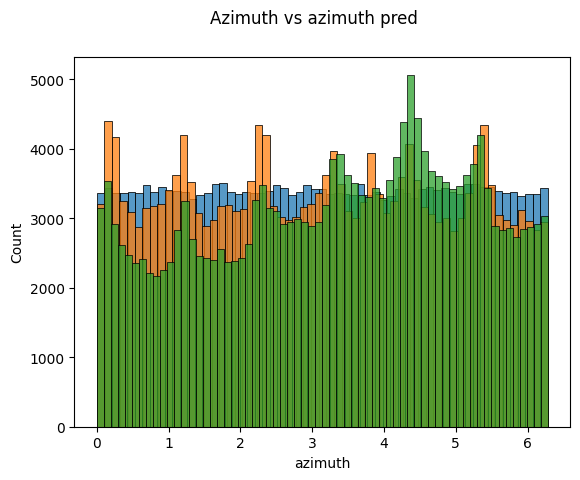

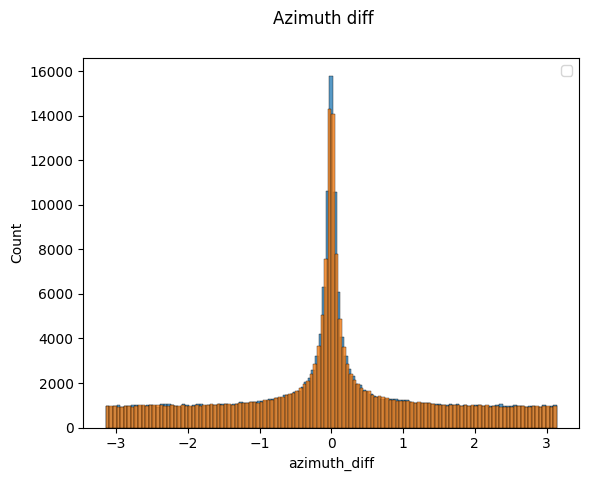

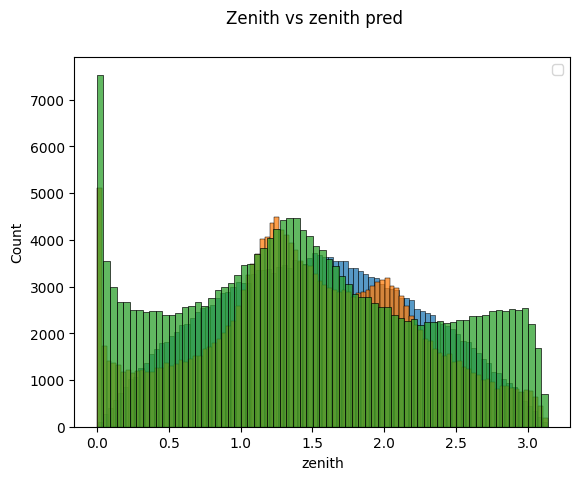

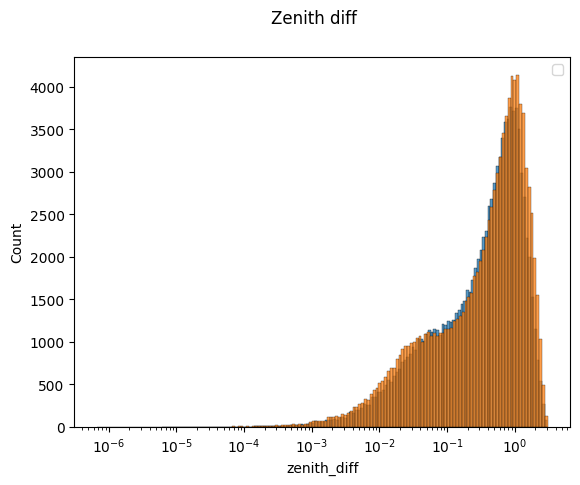

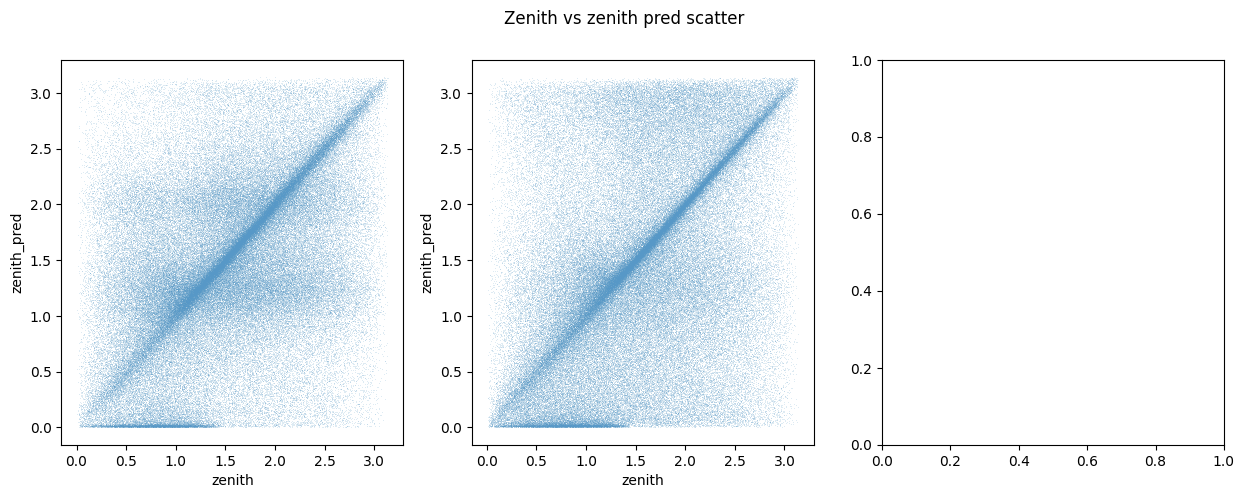

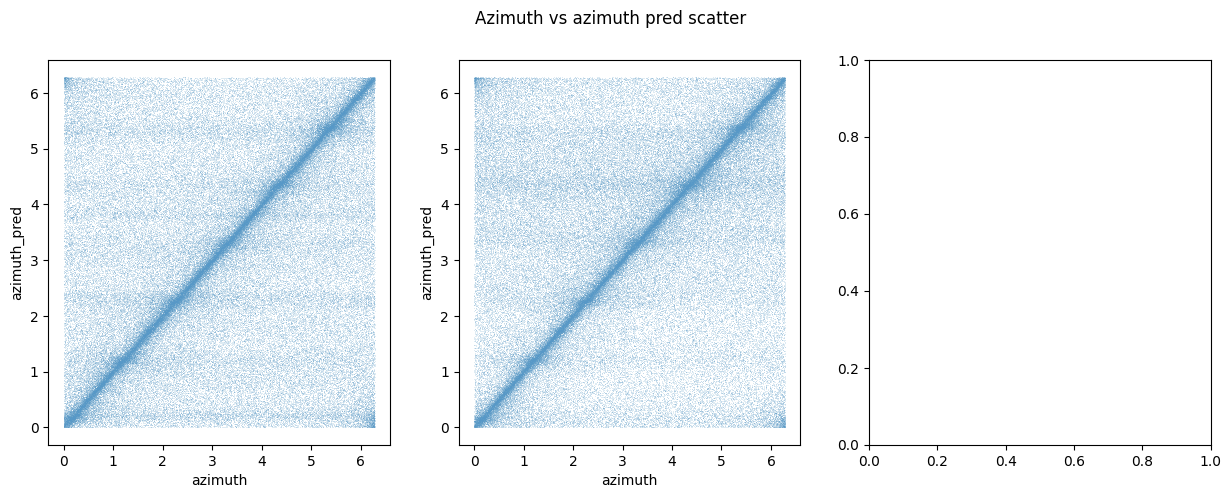

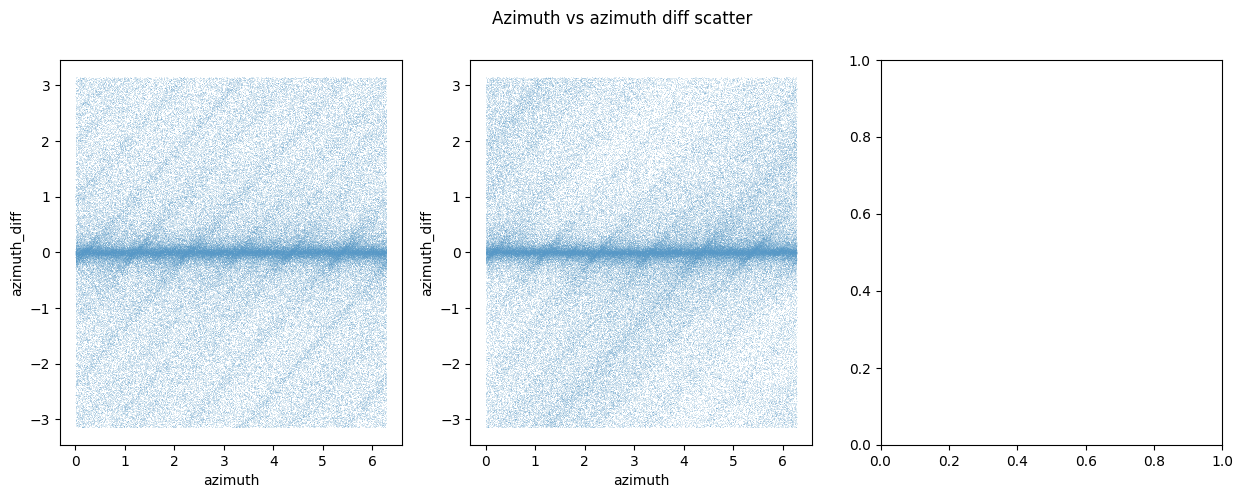

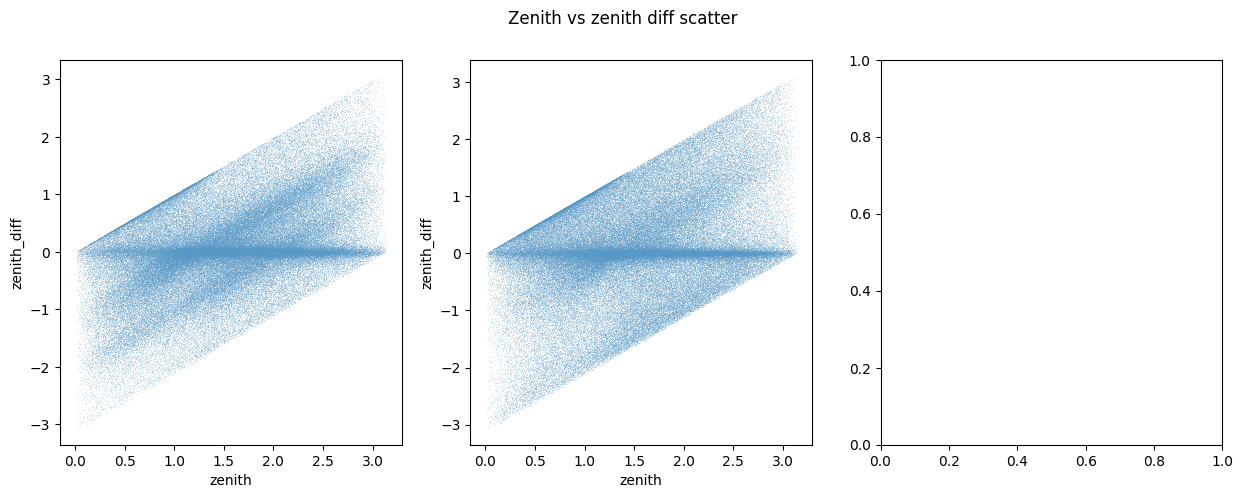

In [10]:
plt.figure()
plt.suptitle('Azimuth vs azimuth pred')
sns.histplot(data=df1, x='azimuth')
sns.histplot(data=df1, x='azimuth_pred')
sns.histplot(data=df2, x='azimuth_pred')
# sns.histplot(data=df, x='azimuth_pred')

plt.figure()
plt.suptitle('Azimuth diff')
sns.histplot(data=df1, x='azimuth_diff')
sns.histplot(data=df2, x='azimuth_diff')
# sns.histplot(data=df, x='azimuth_diff')
plt.legend()

plt.figure()
plt.suptitle('Zenith vs zenith pred')
sns.histplot(data=df1, x='zenith')
sns.histplot(data=df1, x='zenith_pred')
sns.histplot(data=df2, x='zenith_pred')
# sns.histplot(data=df, x='zenith_pred')
plt.legend()

plt.figure()
plt.suptitle('Zenith diff')
sns.histplot(data=df1, x='zenith_diff', log_scale=True)
sns.histplot(data=df2, x='zenith_diff', log_scale=True)
# sns.histplot(data=df, x='zenith_diff', log_scale=True)
plt.legend()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Zenith vs zenith pred scatter')
sns.scatterplot(data=df1, x='zenith', y='zenith_pred', s=0.1, ax=axes[0])
sns.scatterplot(data=df2, x='zenith', y='zenith_pred', s=0.1, ax=axes[1])
# sns.scatterplot(data=df, x='zenith', y='zenith_pred', s=0.1, ax=axes[2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Azimuth vs azimuth pred scatter')
sns.scatterplot(data=df1, x='azimuth', y='azimuth_pred', s=0.1, ax=axes[0])
sns.scatterplot(data=df2, x='azimuth', y='azimuth_pred', s=0.1, ax=axes[1])
# sns.scatterplot(data=df, x='azimuth', y='azimuth_pred', s=0.1, ax=axes[2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Azimuth vs azimuth diff scatter')
sns.scatterplot(data=df1, x='azimuth', y='azimuth_diff', s=0.1, ax=axes[0])
sns.scatterplot(data=df2, x='azimuth', y='azimuth_diff', s=0.1, ax=axes[1])
# sns.scatterplot(data=df, x='azimuth', y='azimuth_diff', s=0.1, ax=axes[2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Zenith vs zenith diff scatter')
sns.scatterplot(data=df1, x='zenith', y='zenith_diff', s=0.1, ax=axes[0])
sns.scatterplot(data=df2, x='zenith', y='zenith_diff', s=0.1, ax=axes[1])
# sns.scatterplot(data=df, x='zenith', y='zenith_diff', s=0.1, ax=axes[2])

In [5]:
n = 30
theta_bins = [0]
for i in range(1, n):
    delta_theta = np.arccos(np.cos(theta_bins[i - 1]) - 2 / n) - theta_bins[i - 1]
    theta_bins.append(theta_bins[i - 1] + delta_theta)
theta_bins.append(np.pi)

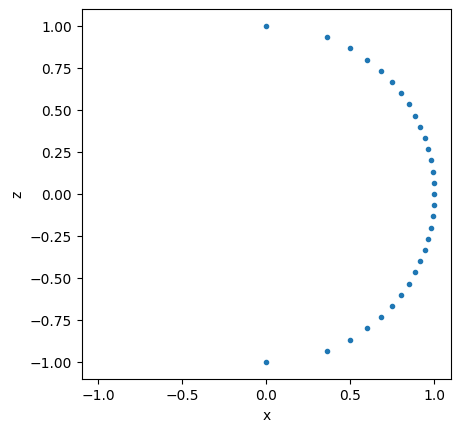

In [6]:
plt.plot(np.sin(theta_bins), np.cos(theta_bins), '.')
plt.xlim((-1.1, 1.1))
plt.ylim((-1.1, 1.1))
plt.xlabel('x')
plt.ylabel('z')
plt.gca().set_aspect('equal')

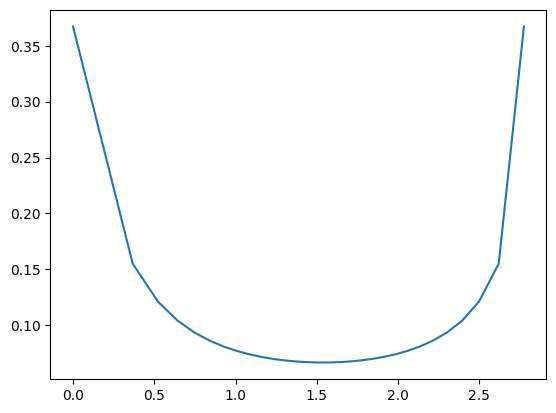

In [128]:
plt.plot(theta_bins[:-1], np.diff(theta_bins))

<Axes: xlabel='temp', ylabel='Count'>

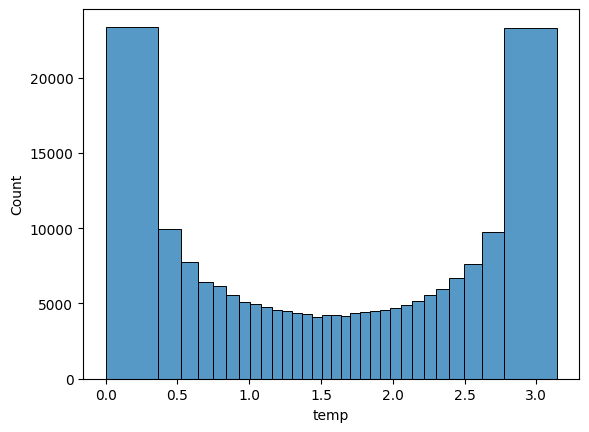

In [129]:
df2['temp'] = np.random.rand(len(df2)) * np.pi
sns.histplot(data=df2, x='temp', bins=theta_bins)

<Axes: xlabel='zenith', ylabel='angular_error'>

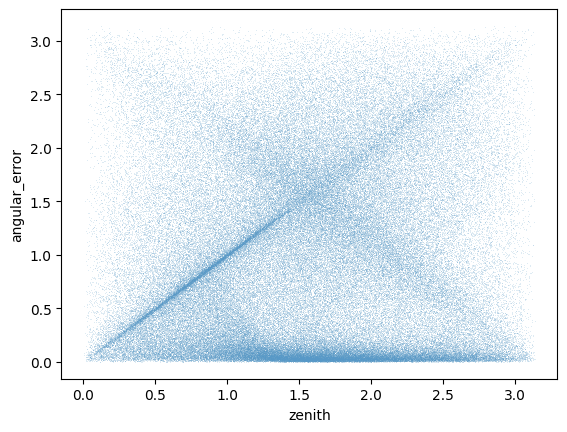

In [94]:
plt.figure()
sns.scatterplot(data=df2, x='zenith', y='angular_error', s=0.1)

<Axes: xlabel='zenith', ylabel='angular_error'>

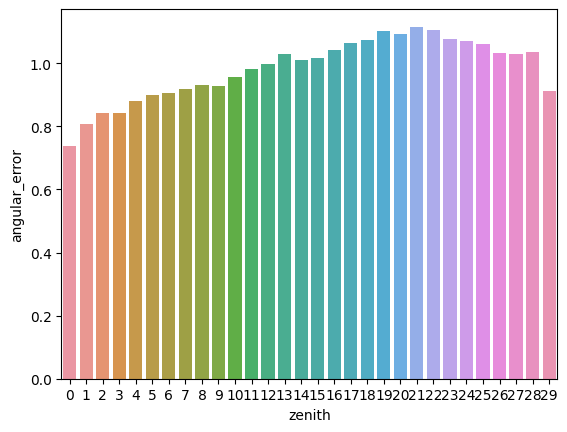

In [90]:
# calculate mean values for each bin
means = df2.groupby(pd.cut(df2['zenith'], bins=30, labels=False))['angular_error'].mean().reset_index()

# plot binplot
sns.barplot(x='zenith', y='angular_error', data=means)

<Axes: xlabel='zenith', ylabel='zenith_diff'>

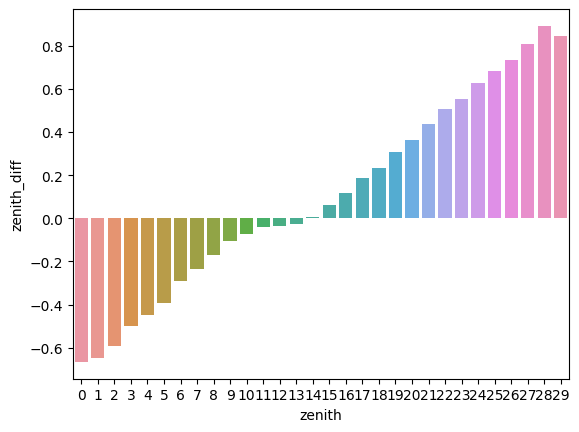

In [98]:
# calculate mean values for each bin
means = df2.groupby(pd.cut(df2['zenith'], bins=30, labels=False))['zenith_diff'].mean().reset_index()

# plot binplot
sns.barplot(x='zenith', y='zenith_diff', data=means)

<Axes: xlabel='azimuth', ylabel='angular_error'>

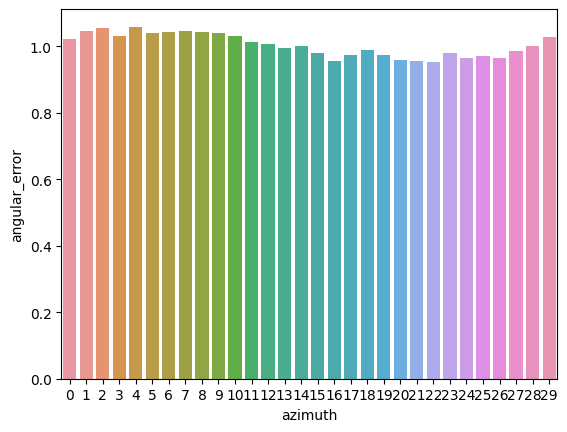

In [91]:
# calculate mean values for each bin
means = df2.groupby(pd.cut(df2['azimuth'], bins=30, labels=False))['angular_error'].mean().reset_index()

# plot binplot
sns.barplot(x='azimuth', y='angular_error', data=means)

<Axes: xlabel='azimuth', ylabel='azimuth_diff'>

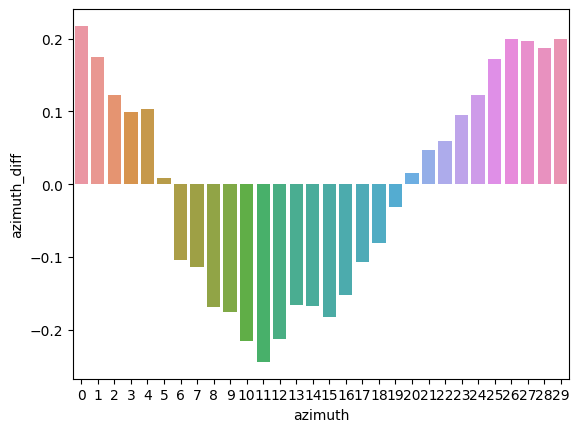

In [102]:
# calculate mean values for each bin
means = df2.groupby(pd.cut(df2['azimuth'], bins=30, labels=False))['azimuth_diff'].mean().reset_index()

# plot binplot
sns.barplot(x='azimuth', y='azimuth_diff', data=means)

<Axes: xlabel='azimuth_bins', ylabel='zenith_bins'>

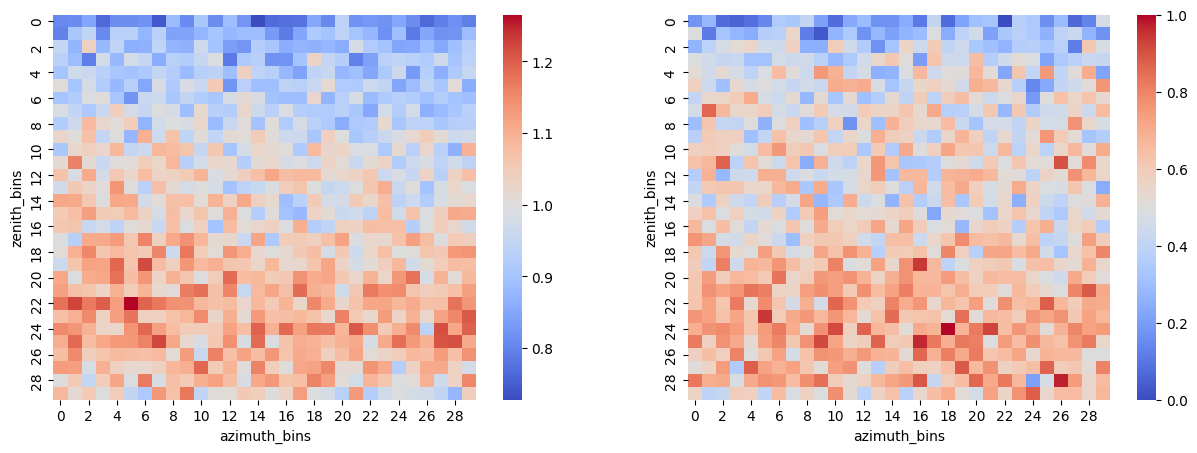

In [139]:
df['azimuth_bins'] = pd.cut(df2['azimuth'], bins=30, labels=False)
df['zenith_bins'] = pd.cut(df2['zenith'], bins=theta_bins, labels=False)
df['count'] = 1
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(
    df.pivot_table(
        values='angular_error', 
        index='zenith_bins', 
        columns='azimuth_bins', 
        aggfunc='mean'
    ), 
    cmap='coolwarm',
    ax=axes[0]
)
df_counts = df.pivot_table(
    values='count',
    index='zenith_bins',
    columns='azimuth_bins',
    aggfunc='sum'
)
df_counts = 1 - (df_counts - df_counts.min().min()) / (df_counts.max().max() - df_counts.min().min())
sns.heatmap(
    df_counts,
    cmap='coolwarm',
    ax=axes[1]
)

NameError: name 'df2' is not defined

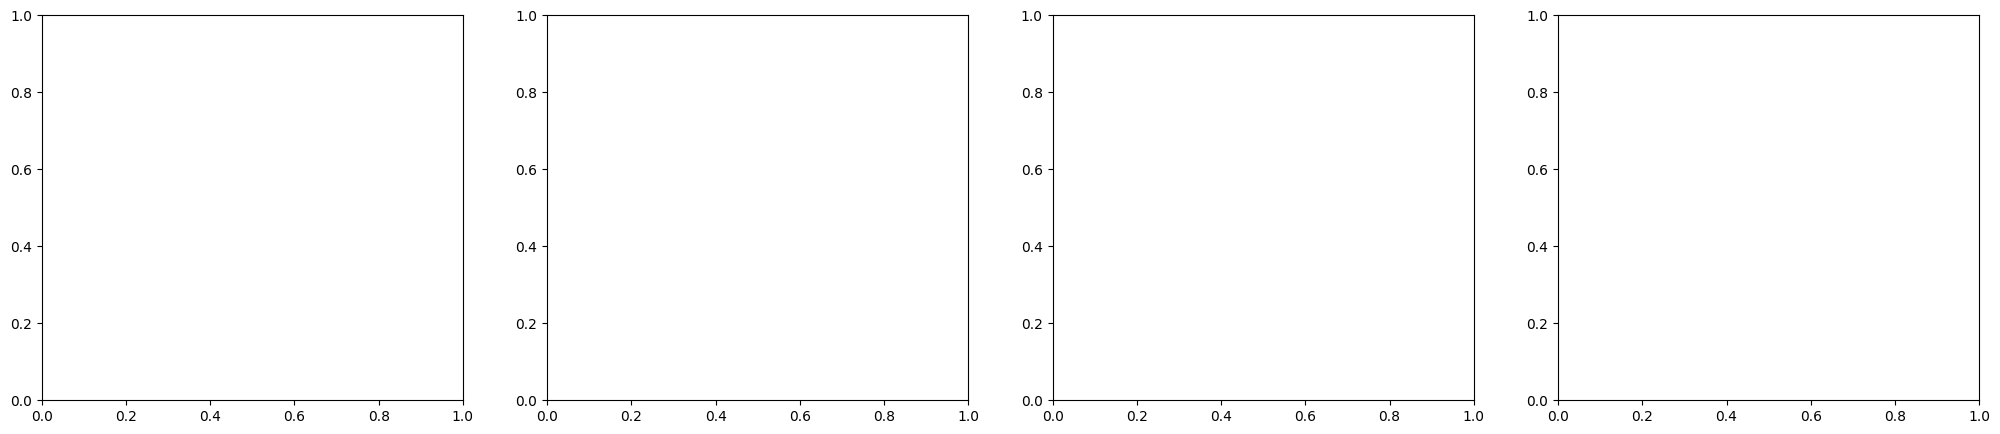

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(25, 5))

sns.histplot(data=df2, x='zenith', bins=theta_bins, stat='probability', ax=axes[0])

counts, _ = np.histogram(df2['zenith'], bins=theta_bins)
indices = np.digitize(df2['zenith'], theta_bins[1:])
# df2['weight'] = 1 / counts[indices]
factor = 1
df2['weight'] = 1 / np.exp((counts[indices] - counts.min()) / (counts.max() - counts.min()) * factor)
# df2['weight'] = df2['weight'] / df2['weight'].mean()

means = df2.groupby(pd.cut(df2['zenith'], bins=theta_bins, labels=False))['weight'].mean().reset_index()
sns.barplot(x='zenith', y='weight', data=means, ax=axes[1])

means = df2.groupby(pd.cut(df2['zenith'], bins=30, labels=False))['angular_error'].mean().reset_index()
sns.barplot(x='zenith', y='angular_error', data=means, axes=axes[2])

df2['weight'] = 1 / np.exp((counts[indices] - counts.min()) / (counts.max() - counts.min()) * factor)


<Axes: xlabel='zenith', ylabel='Count'>

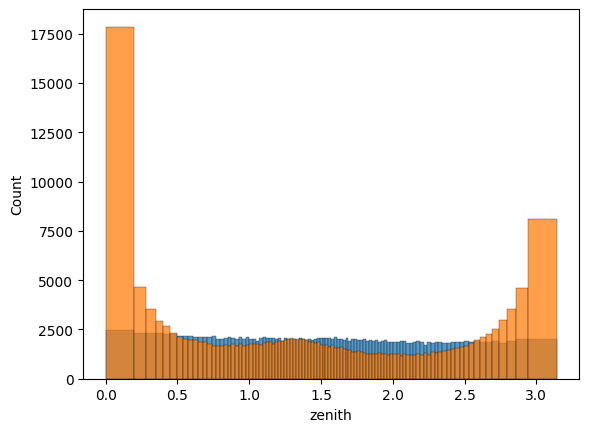

In [70]:
sns.histplot(data=df2, x='zenith', bins=theta_bins)
sns.histplot(data=df2, x='zenith_pred', bins=theta_bins)

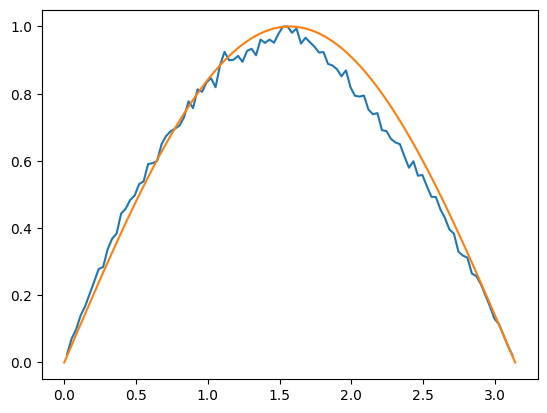

In [46]:
counts, zenith_bins = np.histogram(df2.zenith, bins=100)
strip_heights = np.cos(zenith_bins[:-1]) - np.cos(zenith_bins[1:])
# strip_heights = np.sin(zenith_bins[:-1]) + 0.1
# normalized_counts = counts/(strip_heights/strip_heights.max())
normalized_counts = counts/1
plt.plot((zenith_bins[:-1]+zenith_bins[1:])/2, normalized_counts / normalized_counts.max())
plt.plot(np.linspace(0, np.pi, 100), np.sin(np.linspace(0, np.pi, 100)))

<Axes: xlabel='temp', ylabel='Count'>

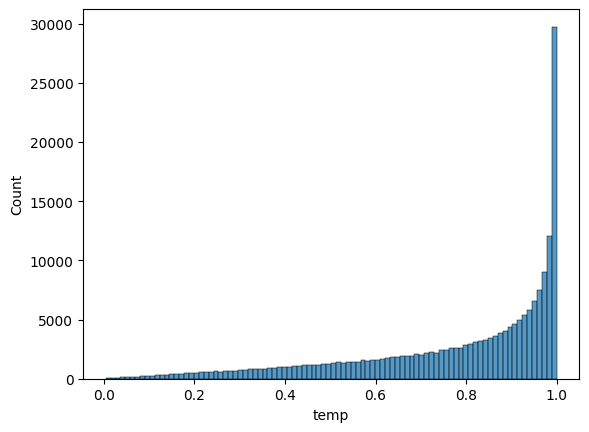

In [47]:
df2['temp'] = np.sin(df2['zenith'])
sns.histplot(data=df2, x='temp')

In [26]:
indices = np.digitize(df2['zenith_pred'], zenith_bins[:-1])
indices[indices > 29] = 29

In [27]:
min(indices)

0

In [28]:
strip_heights[indices]

array([0.05706811, 0.06587011, 0.02734702, ..., 0.03770103, 0.03774654,
       0.05706811])

In [22]:
len(zenith_bins), len(strip_heights)

(31, 30)

<Axes: xlabel='zenith_pred_norm', ylabel='Count'>

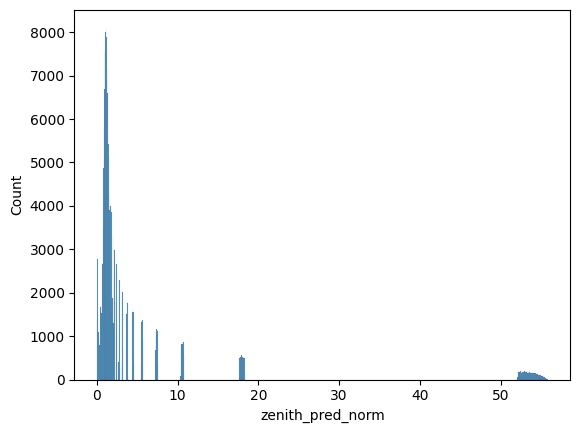

In [32]:
df2['zenith_pred_norm'] = df2['zenith_pred']/(strip_heights[indices]/strip_heights.max())

sns.histplot(data=df2, x='zenith_pred_norm')

In [ ]:
df1['zenith_diff'].abs().mean(), df2['zenith_diff'].abs().mean(), df['zenith_diff'].abs().mean()

In [ ]:
df1['azimuth_diff'].abs().mean(), df2['azimuth_diff'].abs().mean(), df['azimuth_diff'].abs().mean()

In [ ]:
size_multiplier = 1

In [ ]:
%%capture --no-stdout 
config['train_transforms'] = []
config['dynedge']['dynedge_layer_sizes'] = [
    (x * size_multiplier, y * size_multiplier) 
    for x, y in [(128, 256), (336, 256), (336, 256), (336, 256)]
]
config['batch_size'] = 200
config['truth'] = ['zenith', 'azimuth']
# config['target'] = 'direction'
config['target'] = 'direction'
config['path'] = '/workspace/data2/batch_14.db'
config['inference_database_path'] = '/workspace/data2/batch_656.db'
config['bias'] = True
config['max_n_pulses']['max_n_pulses'] = 5000
config['max_n_pulses']['max_n_pulses_strategy'] = 'random'
# config['max_n_pulses']['max_n_pulses'] = None

model, _, _ = build_model_simplex(config, 'weights/direction/state_dict.pth', add_vertices=True)
model.load_state_dict('weights/test/state_dict.pth')

model.prediction_columns = model.simplex_model.net.prediction_columns
model.additional_attributes = model.simplex_model.net.additional_attributes

df = inference(
    model.cuda(), 
    config,
    True
)
df

In [ ]:
df_sensor_geometry = pd.read_csv('data/dataset/sensor_geometry.csv')

In [ ]:
df_sensor_geometry

In [ ]:
import pandas as pd
import sqlite3

my_event_id = 0
my_database = '/workspace/icecube/data/batch_1.db'

def get_event(id, database_path):
    with sqlite3.connect(database_path) as conn:
        # extracts meta data for event
        meta_query = f'SELECT * FROM meta_table WHERE event_id = {id}'
        meta_data = pd.read_sql(meta_query,conn)
        
        # extracts pulses / detector response for event
        pulse_query = f'SELECT * FROM pulse_table WHERE event_id = {id}'
        pulse_data = pd.read_sql(pulse_query, conn)

        return meta_data, pulse_data
    

In [ ]:
df.event_id.astype(int)

In [ ]:
import sqlite3
database_path = '/workspace/icecube/data/batch_656.db'
with sqlite3.connect(database_path) as conn:
    pulse_query = f'SELECT * FROM pulse_table WHERE event_id = {2131983614}'
    df_pulse = pd.read_sql(pulse_query, conn)
df_pulse

In [ ]:
df_pulse['time'].describe()

In [ ]:
df_pulse['charge'].describe()


In [ ]:
import plotly.graph_objects as go
from plotly import tools
import numpy as np
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

data = [
    go.Scatter3d(
        visible = True,
        x = df_sensor_geometry.x,
        y = df_sensor_geometry.y,
        z = df_sensor_geometry.z,
        mode='markers',
        marker=dict(
            size=1,
        )
    ),
    go.Scatter3d(
        visible = True,
        x = df_sensor_geometry.x,
        y = df_sensor_geometry.y,
        z = df_sensor_geometry.z,
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.1,
        )
    )
]

fig = go.Figure(data=data)
fig.layout.scene.camera.projection.type = "orthographic"

iplot(fig, filename='Sine Wave Slider')

In [ ]:
sns.scatterplot(data=df2, x='zenith', y='zenith_diff')

In [ ]:
sns.scatterplot(data=df2, x='azimuth', y='azimuth_diff')

In [ ]:
df1['angular_error'].mean(), df2['angular_error'].mean()

In [ ]:
df1['true_zenith_cos'] = np.cos(df1['zenith'])
df1['true_zenith_sin'] = np.sin(df1['zenith'])
df1['true_azimuth_cos'] = np.cos(df1['azimuth'])
df1['true_azimuth_sin'] = np.sin(df1['azimuth'])

In [ ]:
sns.histplot(data=df1, x='true_azimuth_sin')
sns.histplot(data=df1, x='azimuth_sin')

In [ ]:
sns.histplot(data=df1, x='true_azimuth_cos')
sns.histplot(data=df1, x='azimuth_cos')

In [ ]:
sns.histplot(data=df1, x='true_zenith_sin')
sns.histplot(data=df1, x='zenith_sin')

In [ ]:
sns.histplot(data=df1, x='true_zenith_cos')
sns.histplot(data=df1, x='zenith_cos')

In [ ]:
sns.histplot(data=df1, x='true_x')
sns.histplot(data=df1, x='direction_x')

In [ ]:
sns.histplot(data=df1, x='true_y')
sns.histplot(data=df1, x='direction_y')

In [ ]:
sns.histplot(data=df1, x='true_z')
sns.histplot(data=df1, x='direction_z')

In [ ]:
df['zenith_true_sin'] = np.sin(df['zenith'])
df['zenith_true_cos'] = np.cos(df['zenith'])
sns.histplot(data=df, x='zenith_true_cos')
sns.histplot(data=df, x='zenith_cos')

In [ ]:
sns.histplot(data=df, x='azimuth_true_cos')
sns.histplot(data=df, x='azimuth_cos')

In [ ]:
sns.histplot(data=df, x='zenith_true_cos')
sns.histplot(data=df, x='zenith_cos')

In [ ]:
# df['zenith_pred'] = np.arctan2(df['zenith_sin'], df['zenith_cos'])
# df['zenith_pred'] = np.arccos(df['zenith_cos'])
# df['zenith_sin'] = (1 - df['zenith_cos'] ** 2) ** 0.5
# df['zenith_pred'] = np.arcsin(df['zenith_sin'])
df['zenith_sin'] = np.sin(df['zenith_pred'])
df['zenith_cos'] = np.cos(df['zenith_pred'])

df['azimuth_cos'] = df2['azimuth_cos']
df['azimuth_sin'] = df2['azimuth_sin']
df['direction_x'] = df['azimuth_cos'] * df['zenith_sin']
df['direction_y'] = df['azimuth_sin'] * df['zenith_sin']
df['direction_z'] = df['zenith_cos']

In [ ]:
df[['zenith', 'zenith_pred']].sample(10)

In [ ]:
sns.histplot(data=df, x='zenith')
sns.histplot(data=df, x='zenith_pred')

In [ ]:
df.zenith_diff.abs().mean()

In [ ]:
sns.scatterplot(data=df, x='zenith', y='zenith_diff')
# plt.xlim(0, np.pi)
# plt.ylim(0, np.pi)

In [ ]:
df['zenith_diff'] = df['zenith'] - df['zenith_pred']

In [ ]:
sns.scatterplot(data=df, x='zenith', y='zenith_diff')

In [ ]:
df['true_x'] = np.cos(df['azimuth']) * np.sin(df['zenith'])
df['true_y'] = np.sin(df['azimuth']) * np.sin(df['zenith'])
df['true_z'] = np.cos(df['zenith'])
df['angular_error'] = np.arccos(df['true_x']*df['direction_x'] + df['true_y']*df['direction_y'] + df['true_z']*df['direction_z'])
df

In [ ]:
fig = plt.figure(figsize = (6,6))
plt.hist(df1['angular_error'], 
    bins = np.arange(0,np.pi*2, 0.05), 
    histtype = 'step', 
    label = f'1 mean AE: {np.round(df1["angular_error"].mean(),2)}'
)
plt.hist(df2['angular_error'], 
    bins = np.arange(0,np.pi*2, 0.05), 
    histtype = 'step', 
    label = f'2 mean AE: {np.round(df2["angular_error"].mean(),2)}'
)
plt.hist(df['angular_error'], 
    bins = np.arange(0,np.pi*2, 0.05), 
    histtype = 'step', 
    label = f'merged mean AE: {np.round(df["angular_error"].mean(),2)}'
)
plt.xlabel('Angular Error [rad.]', size = 15)
plt.ylabel('Counts', size = 15)
plt.title(f'{model_name}, Angular Error Distribution (Batch 51)', size = 15)
plt.legend(frameon=False, fontsize=15)